# Interactive sampler

1. train a sampler
2. user can navigate through the sampling process

initialise notebook and logger:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

## train sampler

In [2]:
%%time
'''
FIRST WE TRAIN A GRAPHSAMPLER
'''
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import graphlearn.utils.interactive as interactive


def get_sampler():
    # get training graphs
    training_graphs = gspan_to_eden( '../toolsdata/bursi.pos.gspan' )
    training_size=200
    training_graphs = itertools.islice(training_graphs,training_size)

    #create a sampler and fit on training
    sampler=gl.Sampler(radius_list=[0,1], thickness_list=[2],random_state=42447,
                     min_cip_count=2, min_interface_count=2,decomposergen=interactive.mywrap)
    sampler.fit(training_graphs)

    #prepare interactive module
    interactive.setparameters(sampler)
    return sampler
sampler=get_sampler()
print 'OK'

OK
CPU times: user 6.09 s, sys: 544 ms, total: 6.64 s
Wall time: 13.3 s


## help the sampler to decide which generated graph to accept

You will see a current graph in the middle and 8 graphs to choose from. 

In [3]:
import networkx as nx
from graphlearn.utils import draw
from graphlearn.utils import draw_openbabel as openbabel

# choose a start graph
gr = gspan_to_eden( '../toolsdata/bursi.pos.gspan' )
CURRENT = sampler._sample_init(gr.next())

while True:
    # generate 8 graphs
    graphmanz=interactive.easy_get_new_graphs(CURRENT,sampler)
    # put old one in middle (of the plot)
    g=[grman.base_graph() for grman in graphmanz ]
    g=g[:4]+[CURRENT.base_graph()]+g[4:]
    # draw them 
    #draw.graphlearn(g,n_graphs_per_line=3, node_size=400,contract=True,node_border=0.5)
    openbabel.draw(g,n_graphs_per_line=3,title_key='info')
    
    #pick a graph that is the new CURRENT
    x=raw_input()
    CURRENT=graphmanz[int(x)]
    CURRENT.real_clean()

5


asd


ValueError: invalid literal for int() with base 10: 'asd'

## EXPERT MODE

First choose a node in the graph that you want to change. 
Then select from all available options.


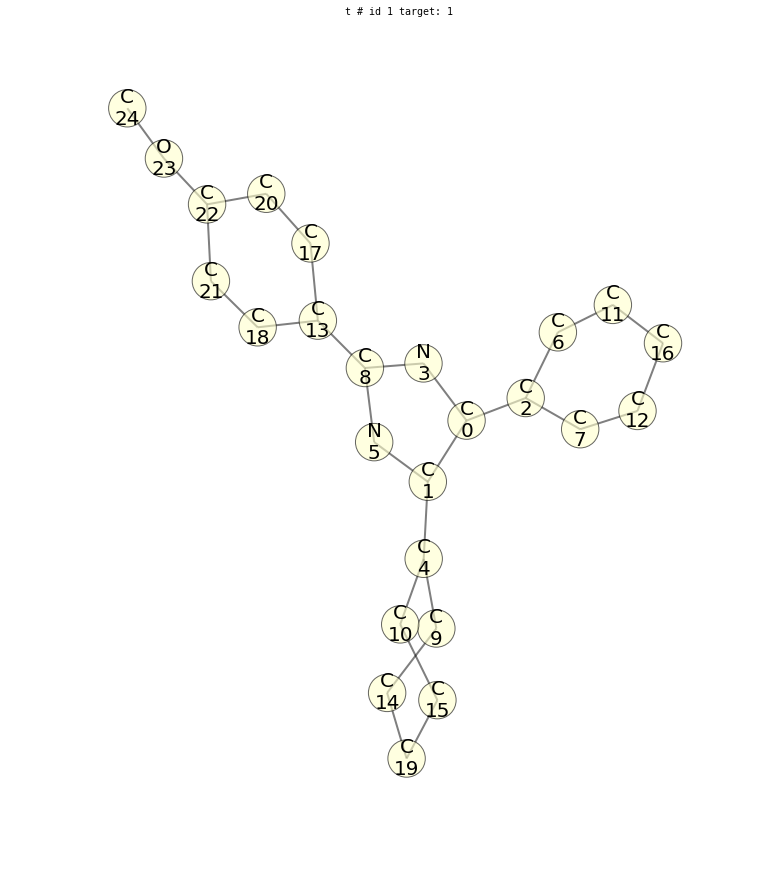

choose a node
16


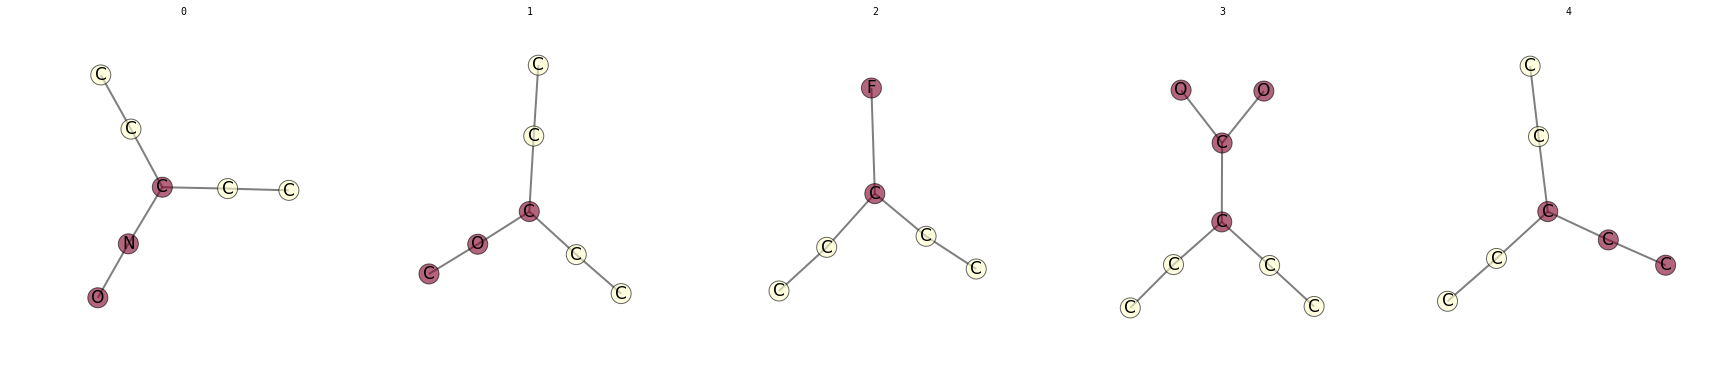

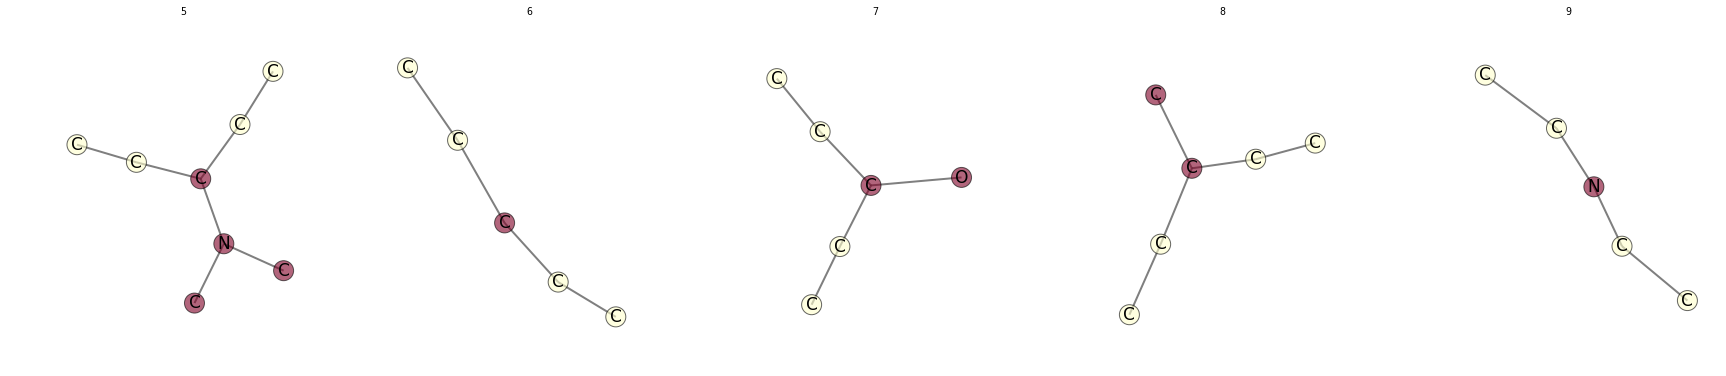

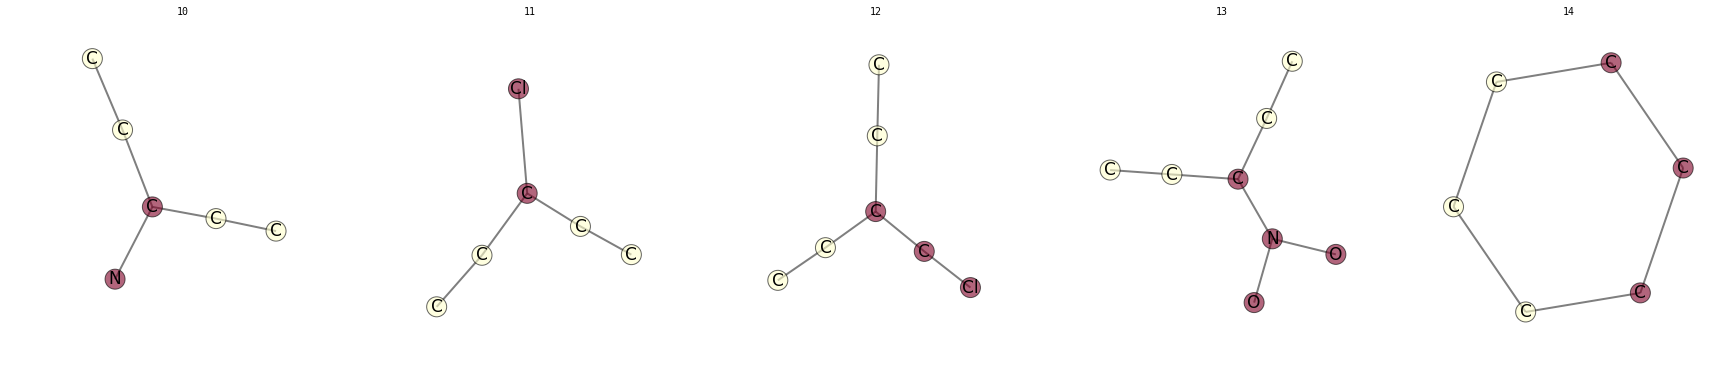

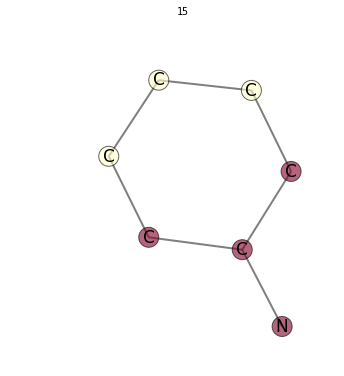

choose a CIP; red nodes will be added
15


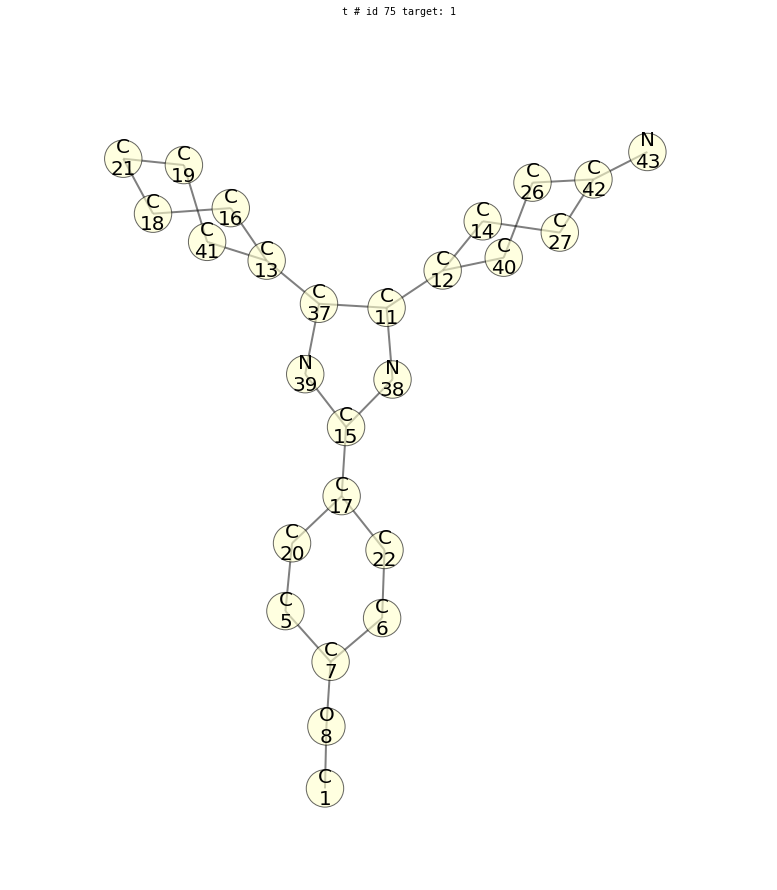

choose a node
asd


ValueError: invalid literal for int() with base 10: 'asd'

In [4]:
import networkx as nx
from graphlearn.utils import draw

sampler=get_sampler()
# initialize and provide a graph to work on
args=interactive.getargz(sampler)
gr = gspan_to_eden( '../toolsdata/bursi.pos.gspan' )
CURRENT = sampler._sample_init(gr.next())


while True: 
    # draw graph and choose node
    draw.graphlearn(CURRENT.base_graph(),secondary_vertex_label='id',size=15,contract=True, node_size=1400,font_size=20,node_border=0.5)
    print "choose a node"
    node_id=int(raw_input())
    
    # draw new cips and choose one
    cips=interactive.get_cips(CURRENT,sampler,node_id,args)
    if len(cips)==0:
        print 'no replacements found,try again'
        continue
    cip_graphs=[ c.graph for c in cips ]
    draw.graphlearn(cip_graphs, node_border=0.5, node_size=400,font_size=17,contract=True,title_key='info')
    print "choose a CIP; red nodes will be added"
    cip_id=int(raw_input())
    
    #replace and clean
    gr=CURRENT.core_substitution( cips[cip_id].orig, cip_graphs[cip_id])
    CURRENT=sampler.decomposer_generator(sampler.graphtransformer.re_transform_single(gr))
    CURRENT.real_clean()

---